# Importing libraries and scripts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
import random

warnings.filterwarnings('ignore')
sys.path.append('..')

from scripts import dataframe as dfr
from scripts import matrix as mx
from scripts import regression as rgr
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score

from collections import Counter

# Downloading the data

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

In [3]:
!wget $data 

--2022-10-13 13:23:15--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv.3’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.1s    

2022-10-13 13:23:16 (527 KB/s) - ‘AER_credit_card_data.csv.3’ saved [73250/73250]



# Preparation

In [4]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df['card'] = (df['card'] == 'yes').astype('int')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1

In [7]:
roc_auc_score(df['card'],df['reports'])

0.28219862090829834

In [8]:
roc_auc_score(df['card'],df['dependents'])

0.4742278935827323

In [9]:
roc_auc_score(df['card'],df['active'])

0.5824680985971309

In [10]:
roc_auc_score(df['card'],df['share'])

0.9898054212570342

# Training the model

In [11]:
usefull_cols = [
    "reports", 
    "age", 
    "income", 
    "share", 
    "expenditure", 
    "dependents", 
    "months", 
    "majorcards", 
    "active", 
    "owner", 
    "selfemp"
    ]

In [12]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[usefull_cols].to_dict(orient='records')
val_dict = df_val[usefull_cols].to_dict(orient='records')

In [13]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# Question 2

In [15]:
y_pred = model.predict_proba(X_val)[:,1]
print('%.3f'%roc_auc_score(y_val,y_pred))

0.995


# Question 3

In [16]:
thresholds = np.linspace(0,1,101)
recall_values = []
precision_values = []
f1_scores = []

for threshold in thresholds:

    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predict_positive = y_pred >= threshold
    predict_negative = y_pred < threshold

    tp = ( actual_positive & predict_positive ).sum()
    tn = ( actual_negative & predict_positive ).sum()
    fp = ( actual_negative & predict_positive).sum()
    fn = ( actual_positive & predict_negative).sum()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp )
    f1 = (2*precision*recall)/(precision+recall)

    recall_values.append(recall)
    precision_values.append(precision)
    f1_scores.append(f1)


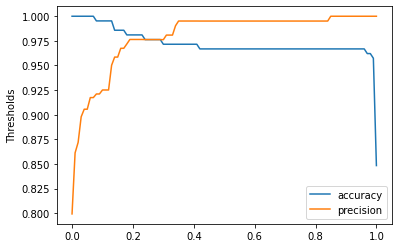

In [17]:
plt.plot(thresholds,recall_values,label='accuracy')
plt.plot(thresholds,precision_values,label='precision')
plt.ylabel('Thresholds')
plt.legend()

# Question 4

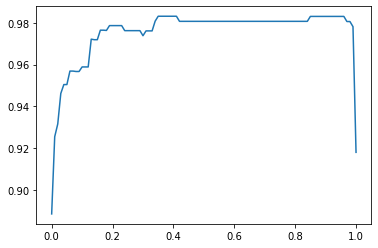

In [18]:
plt.plot(thresholds,f1_scores)

# Question 5

In [19]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [21]:
scores = []

for train_idx , val_idx in tqdm(kfold.split(df_full_train),total=5):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv , model = dfr.train(df_train,y_train,categorical,numerical)
        y_pred = dfr.predict(df_val,categorical,numerical,dv,model)

        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)

100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


In [22]:
round(np.std(scores),3)

0.003

# Question 6

In [23]:
C = [0.01, 0.1, 1, 10]


for c in C:    

    scores = []

    for train_idx , val_idx in tqdm(kfold.split(df_full_train),total=5):
            
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.card
            y_val = df_val.card

            dv , model = dfr.train(df_train,y_train,categorical,numerical,C=c)
            y_pred = dfr.predict(df_val,categorical,numerical,dv,model)

            auc = roc_auc_score(y_val,y_pred)
            scores.append(auc)

    print('C: %.3f Mean Score:%.3f'% (c,np.mean(scores)))

100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


C: 0.010 Mean Score:0.995


100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


C: 0.100 Mean Score:0.996


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


C: 1.000 Mean Score:0.996


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

C: 10.000 Mean Score:0.997
